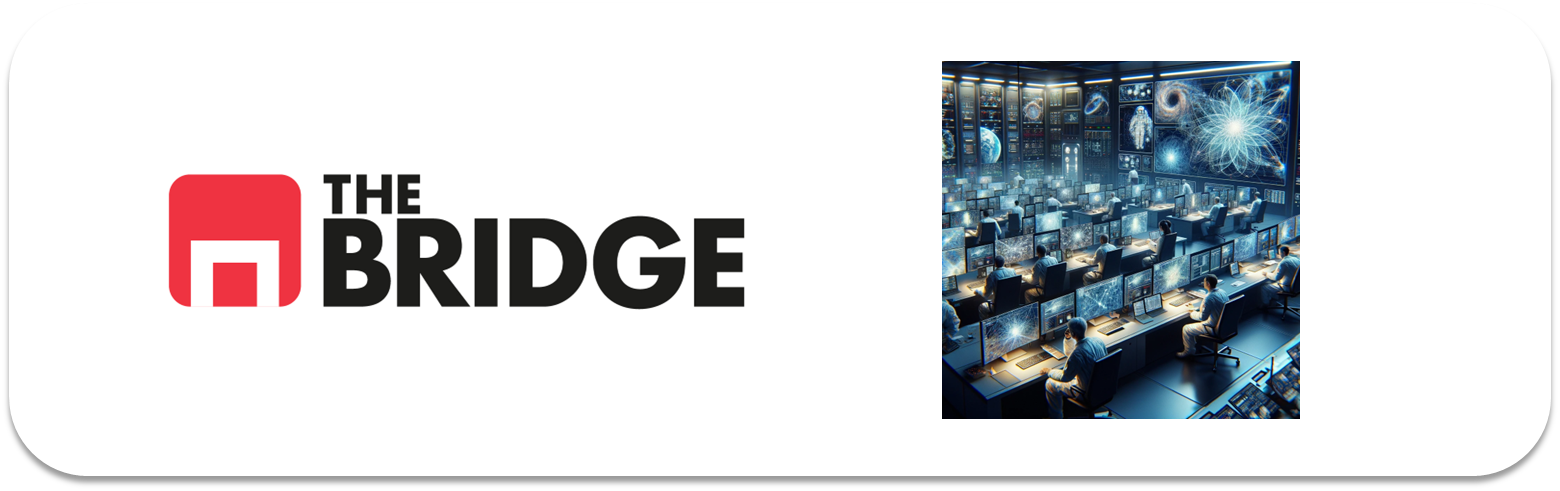

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.io import imread
from sklearn.utils import shuffle
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



## 1. Preparar datos

In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [3]:
def read_data(directorio, reshape_dim = (96,96)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 96x96 para nuestro modelo MobileNetV2

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [4]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [5]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 96, 96, 3)
Y train shape:  (14034,)


In [6]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

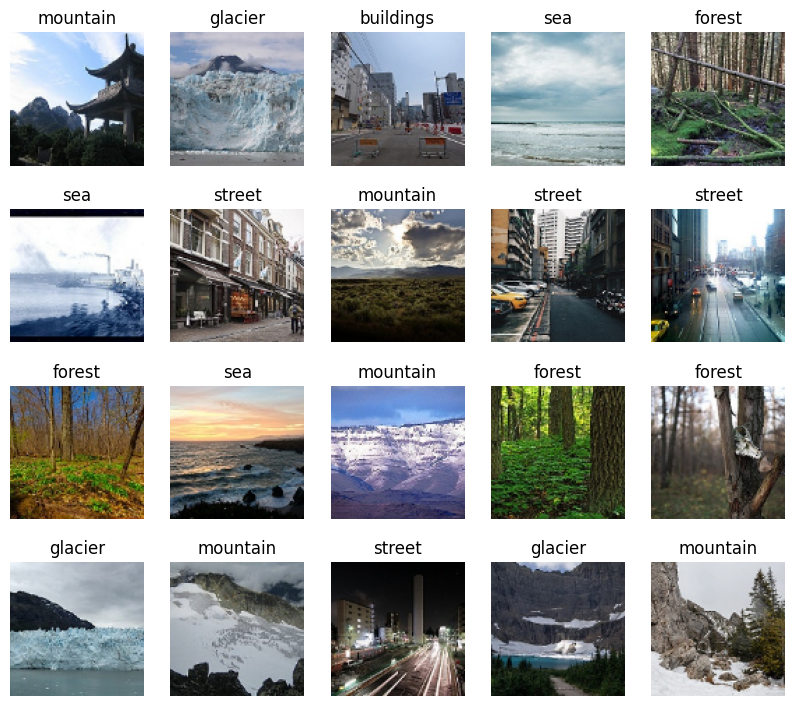

In [7]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [8]:
#MiniEDA
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [9]:
#Normalización
X_train = X_train/255
X_test = X_test/255

## 2. Modelo

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

## 3. Transfer Learning

In [11]:
from tensorflow.keras import datasets, layers, models

In [12]:
# Cargar MobileNetV2 sin la parte superior (top)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(96, 96, 3)
)

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False


# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Observamos la arquitectura del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 3,733,446 (14.24 MB)

 Trainable params: 1,475,462 (5.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [14]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [15]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

In [16]:
#Entrenamiento
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 10,
                    batch_size = 96)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 93s 648ms/step - accuracy: 0.7890 - loss: 0.6995 - val_accuracy: 0.8974 - val_loss: 0.2863
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 78s 614ms/step - accuracy: 0.8952 - loss: 0.2993 - val_accuracy: 0.9074 - val_loss: 0.2683
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 66s 567ms/step - accuracy: 0.9150 - loss: 0.2333 - val_accuracy: 0.9120 - val_loss: 0.2602
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 40s 342ms/step - accuracy: 0.9231 - loss: 0.2086 - val_accuracy: 0.9109 - val_loss: 0.2564
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - accuracy: 0.9295 - loss: 0.1756 - val_accuracy: 0.9134 - val_loss: 0.2750
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 77s 657ms/step - accuracy: 0.9419 - loss: 0.1639 - val_accuracy: 0.9042 - val_loss: 0.3363
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 697ms/step - accuracy: 0.9478 - loss: 0.1426 - val_accuracy: 0.9124 - val_loss: 0.2987
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 78s 667ms/step - accuracy: 0.9537 - loss: 0

In [17]:
evol = pd.DataFrame(history.history)

<Axes: >

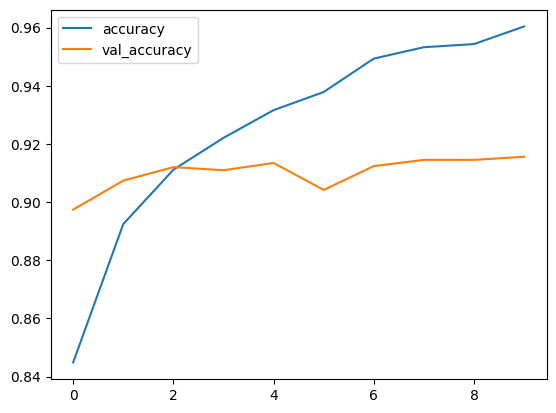

In [18]:
evol[["accuracy","val_accuracy"]].plot()

<Axes: >

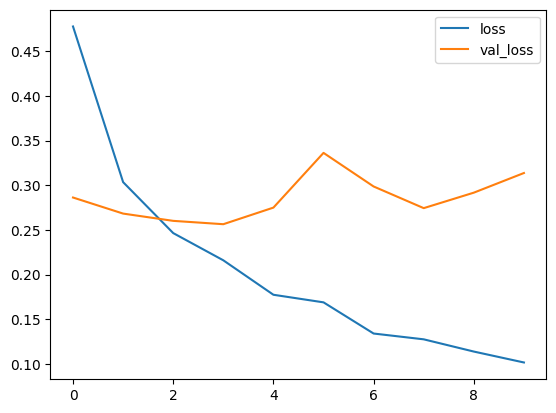

In [19]:
evol[["loss","val_loss"]].plot()

In [20]:
#Evaluación
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.9015 - loss: 0.3643


[0.3052237033843994, 0.9136666655540466]

In [21]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 306ms/step


In [22]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.94      0.87      0.91       437
      forest       1.00      0.99      0.99       474
     glacier       0.85      0.86      0.85       553
    mountain       0.88      0.85      0.87       525
         sea       0.93      0.96      0.95       510
      street       0.90      0.95      0.93       501

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.92      3000
weighted avg       0.91      0.91      0.91      3000



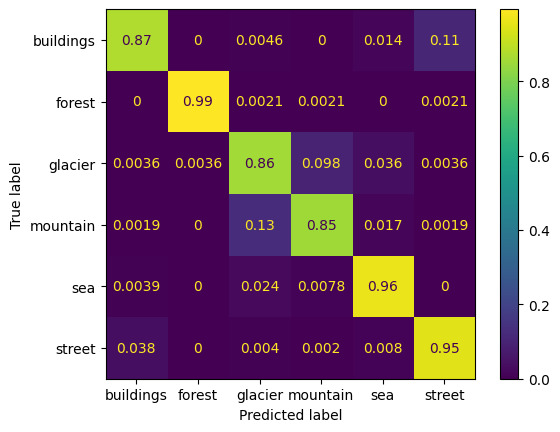

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

## 4. Fine Tuning

In [30]:
# Descongelar solo las últimas capas del modelo base
for layer in base_model.layers[-2:]: 
    layer.trainable = True

# Recompilar con un learning rate más bajo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 12,
                    batch_size = 96)

Epoch 1/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 133s 981ms/step - accuracy: 0.9936 - loss: 0.0232 - val_accuracy: 0.9077 - val_loss: 0.6005
Epoch 2/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 991ms/step - accuracy: 0.9941 - loss: 0.0185 - val_accuracy: 0.9092 - val_loss: 0.6266
Epoch 3/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 142s 987ms/step - accuracy: 0.9940 - loss: 0.0184 - val_accuracy: 0.9113 - val_loss: 0.6748
Epoch 4/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 141s 980ms/step - accuracy: 0.9944 - loss: 0.0146 - val_accuracy: 0.9181 - val_loss: 0.5670
Epoch 5/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 139s 952ms/step - accuracy: 0.9930 - loss: 0.0215 - val_accuracy: 0.9134 - val_loss: 0.7410
Epoch 6/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 955ms/step - accuracy: 0.9916 - loss: 0.0299 - val_accuracy: 0.9049 - val_loss: 0.6709
Epoch 7/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 145s 982ms/step - accuracy: 0.9961 - loss: 0.0128 - val_accuracy: 0.8878 - val_loss: 0.8673
Epoch 8/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 130s 874ms/step - accuracy: 0.9945 -

In [32]:
#Evaluación
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - accuracy: 0.8844 - loss: 0.8235


[0.9031049013137817, 0.875]

In [33]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 354ms/step


In [34]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.87      0.93      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.95      0.58      0.72       553
    mountain       0.69      0.94      0.80       525
         sea       0.92      0.96      0.94       510
      street       0.94      0.89      0.91       501

    accuracy                           0.88      3000
   macro avg       0.89      0.88      0.88      3000
weighted avg       0.89      0.88      0.87      3000



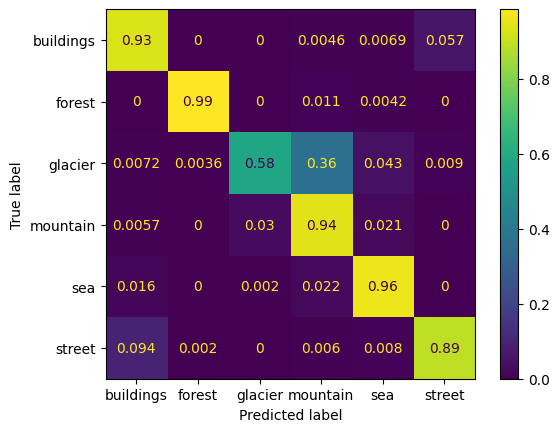

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

## 5. Comparación con resultados Redes Convolucionales

***RESULTADOS RED CONVOLUCIONAL:***

| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|----------|---------|
| buildings | 0.69      | 0.59   | 0.64     | 437     |
| forest     | 0.83      | 0.90   | 0.86     | 474     |
| glacier    | 0.63      | 0.79   | 0.70     | 553     |
| mountain   | 0.61      | 0.72   | 0.66     | 525     |
| sea        | 0.77      | 0.43   | 0.55     | 510     |
| street     | 0.73      | 0.73   | 0.73     | 501     |

**Overall Metrics**

| Metric        | Value |
|---------------|--------|
| Accuracy      | 0.70   |
| Macro Avg F1  | 0.69   |
| Weighted Avg F1 | 0.69 |

***RESULTADOS FINE-TUNING:***

| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|----------|---------|
| buildings | 0.87      | 0.93   | 0.90     | 437     |
| forest     | 0.99      | 0.99   | 0.99     | 474     |
| glacier    | 0.95      | 0.58   | 0.72     | 553     |
| mountain   | 0.69      | 0.94   | 0.80     | 525     |
| sea        | 0.92      | 0.96   | 0.94     | 510     |
| street     | 0.94      | 0.89   | 0.91     | 501     |

**Overall Metrics**

| Metric             | Value |
|--------------------|--------|
| Accuracy           | 0.88   |
| Macro Avg F1-score | 0.88   |
| Weighted Avg F1    | 0.87   |

*Accuracy global sube del 70% al 88%, un salto significativo.*

*El fine-tuning ha sido eficaz, pero se debería revisar la clase glacier para mejorar su sensibilidad (recall).*